<a href="https://colab.research.google.com/github/cbsobral/ml-fies/blob/main/Module02a_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module 02a - ANN

In this module, we perform the following steps:

1. Load the data from Mod_00 and create sets and targets for train and test datasets;
2. 

### 1 - Load Data

Here, we import the training and testing sets created in Module00_Data. 


In [8]:
import pandas as pd

url_train = "https://drive.google.com/file/d/1IP7jyXkLgD_Ouy5cL6fJk4VUA5qRB2PK/view?usp=sharing"
path_train = "https://drive.google.com/uc?export=download&id="+url_train.split("/")[-2]
train = pd.read_csv(path_train)
train.shape

(351001, 31)

In [9]:
url_test = "https://drive.google.com/file/d/1v4FqKwt7NzG5RM6d9f1y7CLIdKq69jSS/view?usp=sharing"
path_test = "https://drive.google.com/uc?export=download&id="+url_test.split("/")[-2]
test = pd.read_csv(path_test)
test.shape

(87751, 31)

In [10]:
train_set = train.drop("default", axis=1) # drop targets for training set
train_target = train["default"].copy()

In [11]:
test_set = test.drop("default", axis=1) # drop targets for test set
test_target = test["default"].copy()

### 2 - Pipeline

The pipeline contains functions that will be used to transform the dataset. For the numeric attributes, the stardardization is performed by the StandardScaler. For ordinal attributes, variables are encoded by the OrdinalEncoder, and for categorical, theOneHotEncoder. 

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
        ("num_imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler()),
    ])

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

ord_pipeline = Pipeline([
        ("ord_imputer", SimpleImputer(strategy="most_frequent")),
        ("ord_encoder", OrdinalEncoder()),
    ])

In [14]:
ord_attribs = ["igc","date_contract"] # 2 attributes

num_attribs = ["family_income",   #17
               "personal_income",
               "high_school_endyear",
               "n_sem_course",
               "n_completed_sem",
               "sem_funded",
               "fam_size",
               "income_pc",
               "tuition_current",
               "inc_prop",
               "perc_requested",
               "loan_value_sem",
               "student_resource",
               "loan_value",
               "loan_limit",
               "total_debt",
               "age"]
  

cat_attribs = ["semester_enroll",  #9
               "gender",
               "occupation", 
               "marital_status",
               "ethnicity", 
               "public_hs", 
               "state_course", 
               "degree", 
               "contract_phase"]

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        ("ord", ord_pipeline, ord_attribs)
        ])

In [16]:
train_prepared = full_pipeline.fit_transform(train_set)
train_prepared[:1]

<1x94 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

In [17]:
test_prepared = full_pipeline.fit_transform(test_set)
test_prepared[:1]

<1x94 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

### 3 - Sampling 


In [ ]:
import imblearn

# undersampling
undersample = RandomUnderSampler(sampling_strategy=0.5)
data_under, target_under = undersample.fit_resample(train_prepared, train_target)

In [ ]:
# oversampling
oversample = RandomOverSampler(sampling_strategy=0.5)
data_over, target_over = oversample.fit_resample(train_prepared, train_target)

### 4 - Hyperparameters

In [34]:
from sklearn.neural_network import MLPClassifier

ann = MLPClassifier(max_iter=1000, random_state=42)
#ann.fit(train_prepared, train_target.values.ravel())

In [36]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {'hidden_layer_sizes': [(10,30,10),(20,)],
                  'activation': ['tanh', 'relu'],
                  'solver': ['sgd', 'adam'],
                  'alpha': [0.0001, 0.05],
                  'learning_rate': ['constant','adaptive']}

grid_search = GridSearchCV(ann, parameter_grid, n_jobs=-1, cv=3, scoring = 'roc_auc')

In [ ]:
# perform grid search on original train set 
grid_search = grid_search.fit(train_prepared, train_target)
grid_search.best_params_

In [ ]:
# perform grid search on undersample train set 
grid_search_under = grid_search.fit(data_under, target_under)
grid_search_under.best_params_

In [ ]:
# perform grid search on oversample train set 
grid_search_over = grid_search.fit(data_over, target_over)
grid_search_over.best_params_

### 5 - Performance Evaluation

Here, we calculate AUC and Brier scores for the classifiers. 

#### Training Set

In [ ]:
from sklearn.model_selection import cross_val_score

cross_ann = (cross_val_score(ann, train_prepared, train_target, cv=2, scoring="roc_auc")).mean()

In [ ]:
# List with AUC scores for training set
cross_list = [cross_logr, cross_dtc, cross_rf, cross_svm, cross_ann]
m1_list = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Linear SVC', 'ANN']

# Dataframe 
cross_df = pd.DataFrame({"Model": m1_list, "AUC": cross_list})
cross_df.sort_values(by = "AUC", ascending=False)

,Model,AUC
4,ANN,0.816213
2,Random Forest,0.775061
0,Logistic Regression,0.722902
3,Linear SVC,0.672063
1,Decision Tree,0.634598


#### Test Set

In this section, AUC and Brier scores were not calculated for the linear SVC model because it does not have a *predict_proba* function.


In [ ]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for test set
pred_logr = logr.predict_proba(test_prepared)
pred_dtc = dtc.predict_proba(test_prepared)
pred_rf = rf.predict_proba(test_prepared)
pred_ann = ann.predict_proba(test_prepared)

In [ ]:
from sklearn.metrics import roc_auc_score

# AUC score
auc_logr = roc_auc_score(test_target, pred_logr[:,1])
auc_dtc = roc_auc_score(test_target, pred_dtc[:,1])
auc_rf = roc_auc_score(test_target, pred_rf[:,1])
auc_ann = roc_auc_score(test_target, pred_ann[:,1])

In [ ]:
from sklearn.metrics import brier_score_loss

loss_logr = brier_score_loss(test_target, pred_logr[:,1])
loss_dtc = brier_score_loss(test_target, pred_dtc[:,1])
loss_rf = brier_score_loss(test_target, pred_rf[:,1])
loss_ann = brier_score_loss(test_target, pred_ann[:,1])

In [ ]:
# List with AUC scores
auc_list = [auc_logr, auc_dtc, auc_rf, auc_ann]

# List with Brier Scores
loss_list = [loss_logr, loss_dtc, loss_rf, loss_ann]

# List with model names
m2_list = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'ANN']

# Dataframe 
auc_df= pd.DataFrame({"Model": m2_list, "AUC": auc_list, "BS": loss_list})
auc_df.sort_values(by = "AUC", ascending=False)

,Model,AUC,BS
3,ANN,0.818925,0.168184
2,Random Forest,0.783603,0.183829
0,Logistic Regression,0.723212,0.204220
1,Decision Tree,0.644223,0.340680


The AUC results can be plotted, as shown bellow. 

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr_logr, tpr_logr, thresh_logr = roc_curve(test_target, pred_logr[:,1], pos_label=1)
fpr_dtc, tpr_dtc, thresh_dtc = roc_curve(test_target, pred_dtc[:,1], pos_label=1)
fpr_rf, tpr_rf, thresh_rf = roc_curve(test_target, pred_rf[:,1], pos_label=1)
#fpr_svm, tpr_svm, thresh_svm = roc_curve(test_target, pred_svm[:,1], pos_label=1)
fpr_ann, tpr_ann, thresh_ann = roc_curve(test_target, pred_ann[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_target))]
p_fpr, p_tpr, _ = roc_curve(test_target, random_probs, pos_label=1)

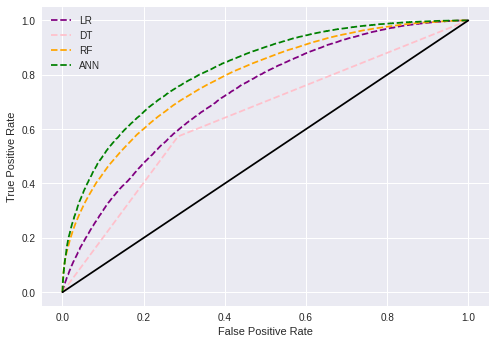

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

# plot roc curves
plt.plot(fpr_logr, tpr_logr, linestyle="--",color="purple", label="LR")
plt.plot(fpr_dtc, tpr_dtc, linestyle="--",color="pink", label="DT")
plt.plot(fpr_rf, tpr_rf, linestyle="--",color="orange", label="RF")
#plt.plot(fpr_svm, tpr_svm, linestyle="--",color="red", label="SVM")
plt.plot(fpr_ann, tpr_ann, linestyle="--",color="green", label="ANN")
plt.plot(p_fpr, p_tpr, linestyle="-", color="black")

# x label
plt.xlabel("False Positive Rate")
# y label
plt.ylabel("True Positive Rate")

plt.legend(loc="best")
plt.savefig("ROC", dpi = 300)
plt.show()